In [1]:
!pip -q install tensorflow_text tensorflow tensorflow_hub 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

2024-05-31 14:38:39.104493: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 14:38:39.104619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 14:38:39.230224: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('/kaggle/input/spam-email-big/emails.csv')
df.head(5)

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
df['spam'].value_counts()

spam
0    4360
1    1368
Name: count, dtype: int64

In [5]:
df_ham = df[df['spam'] == 0]
df_ham.shape

(4360, 2)

In [6]:
df_spam = df[df['spam'] == 1]
df_spam.shape

(1368, 2)

In [7]:
df_ham_down = df_ham.sample(df_spam.shape[0])
df_ham_down.shape

(1368, 2)

In [8]:
df_ham_down['spam'].value_counts()

spam
0    1368
Name: count, dtype: int64

In [9]:
df_balanced = pd.concat([df_ham_down, df_spam])
df_balanced.shape

(2736, 2)

In [10]:
df_balanced['spam'].value_counts()

spam
0    1368
1    1368
Name: count, dtype: int64

In [11]:
# df_balanced['spam'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)

In [12]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(df_balanced['text'], df_balanced['spam'], test_size=0.2, stratify=df_balanced['spam'])

In [13]:
X_train.head()

1919    Subject: re : a visit  dear mr . fujita :  tha...
818     Subject: 1000 ' s of computer products on sale...
307     Subject: visual identity and logo now  working...
2381    Subject: trash bash event on saturday , march ...
4914    Subject: hi vince ,  after we hung up the phon...
Name: text, dtype: object

In [14]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")

In [15]:
text_test = ['this is such an amazing movie!']

In [16]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)


l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1,activation = 'sigmoid', name = 'output')(l)

model = tf.keras.Model(inputs = [text_input], outputs = [l])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [18]:
len(X_train)

2188

In [19]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall')
]

model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = METRICS)


In [20]:
model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
 1/69 [..............................] - ETA: 8:24 - loss: 0.7165 - accuracy: 0.4375 - precision: 0.4211 - recall: 0.5333

I0000 00:00:1717166356.668332      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


69/69 [==============================] - 14s 91ms/step - loss: 0.5565 - accuracy: 0.7299 - precision: 0.7384 - recall: 0.7121
Epoch 2/10
69/69 [==============================] - 6s 90ms/step - loss: 0.3797 - accuracy: 0.8661 - precision: 0.8631 - recall: 0.8702
Epoch 3/10
69/69 [==============================] - 6s 90ms/step - loss: 0.3176 - accuracy: 0.8830 - precision: 0.8851 - recall: 0.8803
Epoch 4/10
69/69 [==============================] - 6s 90ms/step - loss: 0.2867 - accuracy: 0.8844 - precision: 0.8833 - recall: 0.8857
Epoch 5/10
69/69 [==============================] - 6s 92ms/step - loss: 0.2677 - accuracy: 0.8912 - precision: 0.8912 - recall: 0.8912
Epoch 6/10
69/69 [==============================] - 6s 90ms/step - loss: 0.2480 - accuracy: 0.9031 - precision: 0.9002 - recall: 0.9068
Epoch 7/10
69/69 [==============================] - 6s 89ms/step - loss: 0.2381 - accuracy: 0.9022 - precision: 0.9029 - recall: 0.9013
Epoch 8/10
69/69 [==============================] - 6s 90m

In [21]:
model.evaluate(X_test, y_test)

18/18 [==============================] - 2s 87ms/step - loss: 0.2141 - accuracy: 0.9234 - precision: 0.9113 - recall: 0.9380


[0.2141256183385849, 0.9233576655387878, 0.911347508430481, 0.9379562139511108]

In [22]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

18/18 [==============================] - 2s 84ms/step


In [23]:
y_predicted = np.where(y_predicted > 0.5 , 1, 0)
y_predicted

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[249,  25],
       [ 17, 257]])

Text(50.722222222222214, 0.5, 'Truth')

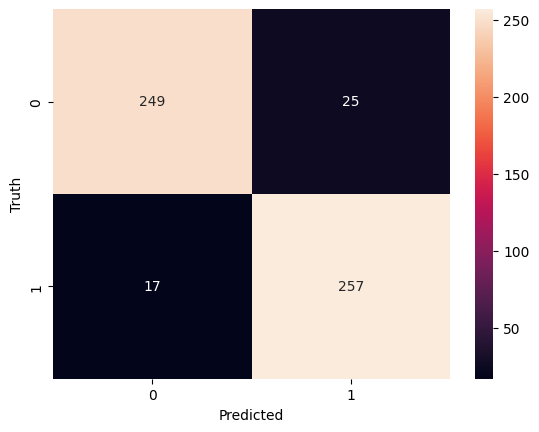

In [25]:
import seaborn as sns

sns.heatmap(cm, annot= True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [26]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       274
           1       0.91      0.94      0.92       274

    accuracy                           0.92       548
   macro avg       0.92      0.92      0.92       548
weighted avg       0.92      0.92      0.92       548

